In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pickle
from skimage import io
from ipyplot import plot_images
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import pytorch_lightning as pl
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from matplotlib import colors, pyplot as plt
%matplotlib inline

# import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)



In [2]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [3]:
# разные режимы датасета 
# DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 640 // 2
BATCH_SIZE = 64
# работаем на видеокарте
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
class BlurDataset(Dataset):
    def __init__(self, df, transform=None):
        # Загружаем датафрейм
        self.data = df
        self.transform = transform

    def __len__(self):
        # Возвращает длину датасета
        return len(self.data)

    def __getitem__(self, idx):
        # Загружаем изображение и метку в сответствии с индексом
        image_name = self.data.iloc[idx, 0]
        image = Image.open(TRAIN_DIR.absolute().as_posix() + '/' + image_name).convert("RGB")
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
class TestBlurDataset(Dataset):
    def __init__(self, test_directory, transform=None):
        self.dir = Path(test_directory)
        self.names = list(self.dir.rglob('*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, index):
        img_name = self.names[index]
        img = Image.open(img_name)
        
        if self.transform:
            img_as_tensor = transform(img)
        return img_name.name, img_as_tensor

In [6]:
transform = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
TRAIN_DIR = Path(r'E:/shift_cv/train/train')
TEST_DIR = Path(r'E:/shift_cv/test/test')

# train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
train_df = pd.read_csv('E:/shift_cv/train.csv')

In [9]:
# Делим выборку
train_files, val_files = train_test_split(train_df, test_size=.2, \
                                         stratify=train_df['blur'], \
                                        random_state=29
                                         )

In [10]:
# Датасеты
train_dataset = BlurDataset(df=train_files, transform=transform)
val_dataset = BlurDataset(df=val_files, transform=transform)
test_dataset = TestBlurDataset(TEST_DIR, transform=transform)


# Даталоадеры
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset)



In [11]:
class BlurClassifier(nn.Module):
    def __init__(self, input_size=(3, 320, 320)):
        super(BlurClassifier, self).__init__()
        self.input_size = input_size

        # Сверточные слои
        self.conv1 = nn.Conv2d(self.input_size[0], 32, kernel_size=3, stride=1, padding=1) # 320x320
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) #160x160
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) #80x80


        # Pooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5)) # Adaptive pooling with output size (5, 5)
        # Dropout
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully-connected layers
        self.fc1 = nn.Linear(128 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 2)

        # Activation functions
        self.relu = nn.ReLU()
        self.relu6 = nn.ReLU6()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
            # Convolutional layers
            x = self.relu6(self.bn1(self.conv1(x)))
            x = self.maxpool(x)
            
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.maxpool(x)
            
            x = self.relu6(self.bn3(self.conv3(x)))
            x = self.maxpool(x)
            x = self.adaptive_pool(x)


#             print(x.shape)

            # Flatten
            x = x.view(x.size(0), -1)
            
            # Fully-connected layers
            x = self.relu6(self.fc1(x))
            x = self.dropout1(x)
            
            x = self.fc2(x)
            
            
            x = self.softmax(x)
            
            return x
            
# Модель на GPU    
model = BlurClassifier().to(device) 

In [12]:
# Тренировка
# Определяем оптимизатор и функцию потерь
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()



# Расписание уменьшения темпа обучения
scheduler = lr_scheduler.StepLR(optimizer, step_size=13, gamma=0.1, verbose=True)

# Проходимся по датасету и обновляем параметры модели
num_epochs = 100 
val_losses = []
train_losses = []
roc_auc = 0
val_loss = 0
train_loss = 0
for epoch in tqdm(range(num_epochs)):
    
    
    if roc_auc > 0.97:
        break
    
    
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        
        # Переносим изображения и метки на видеокарту
        images = images.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # Forward pass
        logits = model(images)
        
        loss = loss_fn(logits, labels)
        #Суммируем потери
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
# Оцениваем модель
# Модель в режим необновления параметров
    model.eval()

    # Списки с правильными и предсказанными метками
    true_labels = []
    pred_probs = []

    # Проходимся по оценочному датасету
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            
            # Данные на GPU
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            logits = model(images)
            # Получаем вероятности
            pred_prob = torch.softmax(logits, dim=1)[:, 1]
            
            # добавляем рельные и предсказанные метки
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(pred_prob.cpu().numpy())
            
            # Суммируем потери на оценке
            val_loss += loss_fn(logits, labels).item()
            
    # Вычисляем потерю на вскх батчах
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Вычисляем ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)
    
    
    print("AUC:", roc_auc)
    print('Train_loss',train_loss, '\n', 'Val_loss:', val_loss)
    

    



Adjusting learning rate of group 0 to 1.0000e-03.


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  1%|▊                                                                                 | 1/100 [00:28<46:26, 28.15s/it]

AUC: 0.6791280331426317
Train_loss 0.7345850257312551 
 Val_loss: 0.6526537934939066
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|█▋                                                                                | 2/100 [00:53<43:42, 26.76s/it]

AUC: 0.7278415015641294
Train_loss 0.6040271485553068 
 Val_loss: 0.6363683210478889
Adjusting learning rate of group 0 to 1.0000e-03.


  3%|██▍                                                                               | 3/100 [01:19<42:25, 26.25s/it]

AUC: 0.7989882478933573
Train_loss 0.5801509846659267 
 Val_loss: 0.6063936021592882
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|███▎                                                                              | 4/100 [01:45<41:33, 25.97s/it]

AUC: 0.8069991263421921
Train_loss 0.5643663502791348 
 Val_loss: 0.61063685019811
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|████                                                                              | 5/100 [02:10<40:52, 25.82s/it]

AUC: 0.792900825747541
Train_loss 0.5356995042632607 
 Val_loss: 0.6220958100424873
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|████▉                                                                             | 6/100 [02:35<40:06, 25.60s/it]

AUC: 0.8987825155708367
Train_loss 0.5175006486037198 
 Val_loss: 0.49590492248535156
Adjusting learning rate of group 0 to 1.0000e-03.


  7%|█████▋                                                                            | 7/100 [03:01<39:31, 25.50s/it]

AUC: 0.8603274807654371
Train_loss 0.49656879901885986 
 Val_loss: 0.5256212419933743
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|██████▌                                                                           | 8/100 [03:26<39:02, 25.47s/it]

AUC: 0.839409012766677
Train_loss 0.50289927685962 
 Val_loss: 0.5818572276168399
Adjusting learning rate of group 0 to 1.0000e-03.


  9%|███████▍                                                                          | 9/100 [03:51<38:30, 25.39s/it]

AUC: 0.8991911619648845
Train_loss 0.47488322503426494 
 Val_loss: 0.5338701804478964
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|████████                                                                         | 10/100 [04:17<38:03, 25.37s/it]

AUC: 0.8659428458698533
Train_loss 0.4596087573205723 
 Val_loss: 0.5866971446408166
Adjusting learning rate of group 0 to 1.0000e-03.


 11%|████████▉                                                                        | 11/100 [04:42<37:39, 25.39s/it]

AUC: 0.8283121494800327
Train_loss 0.458624632042997 
 Val_loss: 0.625328368610806
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█████████▋                                                                       | 12/100 [05:07<37:11, 25.35s/it]

AUC: 0.925076797339571
Train_loss 0.4634803954292746 
 Val_loss: 0.458244178030226
Adjusting learning rate of group 0 to 1.0000e-04.


 13%|██████████▌                                                                      | 13/100 [05:33<36:43, 25.33s/it]

AUC: 0.9381393906941353
Train_loss 0.43786683941588683 
 Val_loss: 0.4820294181505839
Adjusting learning rate of group 0 to 1.0000e-04.


 14%|███████████▎                                                                     | 14/100 [05:58<36:17, 25.32s/it]

AUC: 0.9517797255023532
Train_loss 0.4121880943284315 
 Val_loss: 0.42272433638572693
Adjusting learning rate of group 0 to 1.0000e-04.


 15%|████████████▏                                                                    | 15/100 [06:23<35:50, 25.30s/it]

AUC: 0.9398092044077444
Train_loss 0.4053957988234127 
 Val_loss: 0.43225691715876263
Adjusting learning rate of group 0 to 1.0000e-04.


 16%|████████████▉                                                                    | 16/100 [06:49<35:32, 25.39s/it]

AUC: 0.9458473071611757
Train_loss 0.40449263681383696 
 Val_loss: 0.43253113826115924
Adjusting learning rate of group 0 to 1.0000e-04.


 17%|█████████████▊                                                                   | 17/100 [07:14<35:10, 25.43s/it]

AUC: 0.9422822196544826
Train_loss 0.39653100949876446 
 Val_loss: 0.42859962913725114
Adjusting learning rate of group 0 to 1.0000e-04.


 18%|██████████████▌                                                                  | 18/100 [07:40<34:45, 25.43s/it]

AUC: 0.9495533072175409
Train_loss 0.40701133275733276 
 Val_loss: 0.44018840458658004
Adjusting learning rate of group 0 to 1.0000e-04.


 19%|███████████████▍                                                                 | 19/100 [08:05<34:23, 25.47s/it]

AUC: 0.9594030944395907
Train_loss 0.4011666476726532 
 Val_loss: 0.40797431932555306
Adjusting learning rate of group 0 to 1.0000e-04.


 20%|████████████████▏                                                                | 20/100 [08:31<33:55, 25.45s/it]

AUC: 0.9508074289096187
Train_loss 0.3993896517683478 
 Val_loss: 0.42675597137875027
Adjusting learning rate of group 0 to 1.0000e-04.


 21%|█████████████████                                                                | 21/100 [08:56<33:31, 25.46s/it]

AUC: 0.9650114139165235
Train_loss 0.3956785570172703 
 Val_loss: 0.4090607629881965
Adjusting learning rate of group 0 to 1.0000e-04.


 22%|█████████████████▊                                                               | 22/100 [09:22<33:04, 25.45s/it]

AUC: 0.9585858016514952
Train_loss 0.3966009196113138 
 Val_loss: 0.39653468794292873
Adjusting learning rate of group 0 to 1.0000e-04.


 23%|██████████████████▋                                                              | 23/100 [09:47<32:40, 25.46s/it]

AUC: 0.9580080601978412
Train_loss 0.39266854524612427 
 Val_loss: 0.4119238654772441
Adjusting learning rate of group 0 to 1.0000e-04.


 24%|███████████████████▍                                                             | 24/100 [10:13<32:20, 25.53s/it]

AUC: 0.9540202350421328
Train_loss 0.40188661480651183 
 Val_loss: 0.4142905871073405
Adjusting learning rate of group 0 to 1.0000e-04.


 25%|████████████████████▎                                                            | 25/100 [10:38<31:58, 25.58s/it]

AUC: 0.9607558549164388
Train_loss 0.3986275695702609 
 Val_loss: 0.3913227253490024
Adjusting learning rate of group 0 to 1.0000e-05.


 26%|█████████████████████                                                            | 26/100 [11:06<32:08, 26.06s/it]

AUC: 0.9628836344164812
Train_loss 0.3887031779569738 
 Val_loss: 0.4026671912935045
Adjusting learning rate of group 0 to 1.0000e-05.


 27%|█████████████████████▊                                                           | 27/100 [11:32<31:44, 26.09s/it]

AUC: 0.9602837978750387
Train_loss 0.3842405554126291 
 Val_loss: 0.4007840355237325
Adjusting learning rate of group 0 to 1.0000e-05.


 28%|██████████████████████▋                                                          | 28/100 [11:58<31:15, 26.05s/it]

AUC: 0.9682242200490375
Train_loss 0.3866818906629787 
 Val_loss: 0.3903194699022505
Adjusting learning rate of group 0 to 1.0000e-05.


 29%|███████████████████████▍                                                         | 29/100 [12:24<30:22, 25.67s/it]

AUC: 0.97410731899783
Train_loss 0.38959308406885934 
 Val_loss: 0.38452767001258004


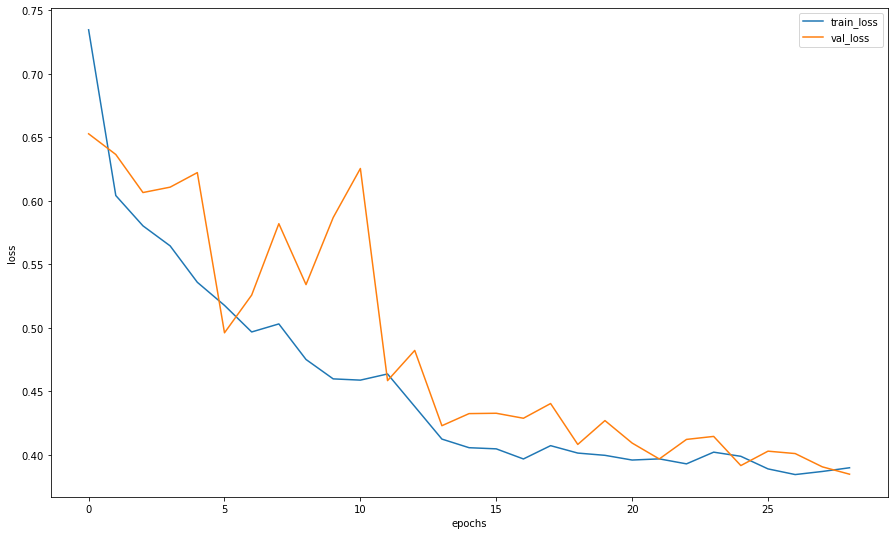

In [13]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [14]:
torch.save(model.state_dict(), 'model.pth')

In [15]:
def submission(model, test_loader):
    model.eval()
    model.to('cpu')
    res = {}
    for name, data in test_loader:
        out = model(data)
        out = torch.softmax(out, dim=1)[:, 1].detach().numpy()
        res[name[0]] = round(float(out), 4)
    data = {'filename': res.keys(), 'blur': res.values()}
    return pd.DataFrame(data=data)


In [16]:
submission = submission(model, test_loader)

In [17]:
submission.to_csv('./submission.csv', index_label=False, index=False)

In [18]:
pd.read_csv('./submission.csv')

,filename,blur
0,aamnsxdfcsnrdkyczxnm.jpg,0.2690
1,acgycwqzujjxrigweldc.jpg,0.2690
2,achfvibipchzipmhtjow.jpg,0.6998
3,adicqesamknapclvcesb.jpg,0.2690
4,aefilcxppgkwhnusvziq.jpg,0.2691
...,...,...
769,zxmhmmdojtrqcpzbfqmo.jpg,0.2690
770,zyeduzrzwbsdfogyaeug.jpg,0.2690
771,zyqqhnasbxwsbnbskifk.jpg,0.2712
772,zytbqidsjtourxzyfasw.jpg,0.2690
